# Steps Labeling
We now label the ski steps using the model we build. Our model classifies each datapoint as either a step (within a step) or a non-step. Now we need to group them neighboring "step" datapoints together to form actual steps.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.lines import Line2D
import joblib

from src.data.labels_util import load_labels, LabelCol, get_labels_file, load_clean_labels, get_workouts
from src.data.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, get_data_chunk,
    normalize_with_bounds, data_to_features, list_imu_abspaths, clean_imu_data
)
from src.data.util import find_nearest, find_nearest_index, shift, low_pass_filter, add_col
from src.data.workout import Activity, Workout
from src.data.data import DataState
from src.data.build_features import main as build_features
from src.data.features_util import list_test_files
from src.model.train import evaluate_model_accuracy, train_model, create_xgboost
from src.model.predict import (
    evaluate_on_test_data, evaluate_on_test_data_plot, evaluate_step_labeling_on_test, 
    display_step_labeling_result_on_test
)
from src.visualization.visualize import multiplot
from src.config import (
    TRAIN_BOOT_DIR, TRAIN_POLE_DIR, TRAIN_FEATURES_FILENAME, TRAIN_LABELS_FILENAME, BOOT_MODEL_FILE, 
    POLE_MODEL_FILE
)

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

## Test data
Perform steps labeling on test data

### Step labeling results

Boot:


<IPython.core.display.Javascript object>


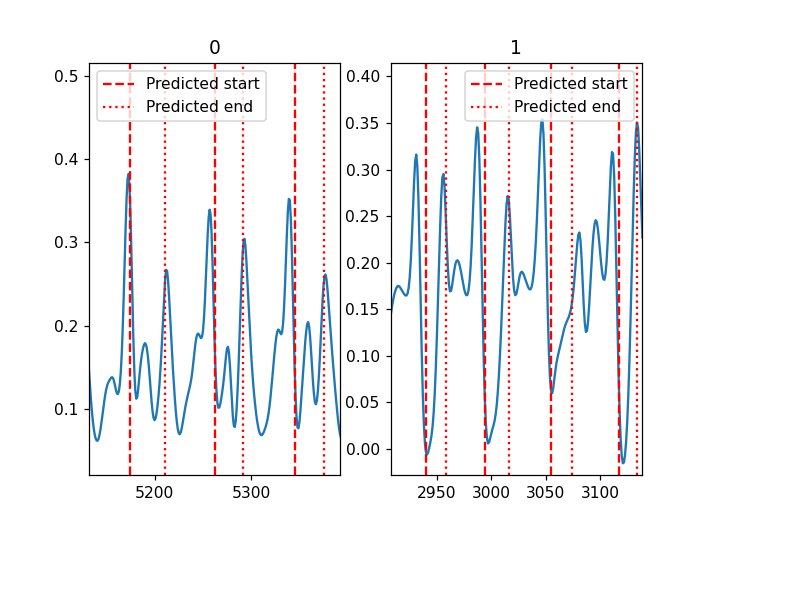

In [2]:
print('Boot:')
display_step_labeling_result_on_test(Activity.Boot)

Pole:


<IPython.core.display.Javascript object>


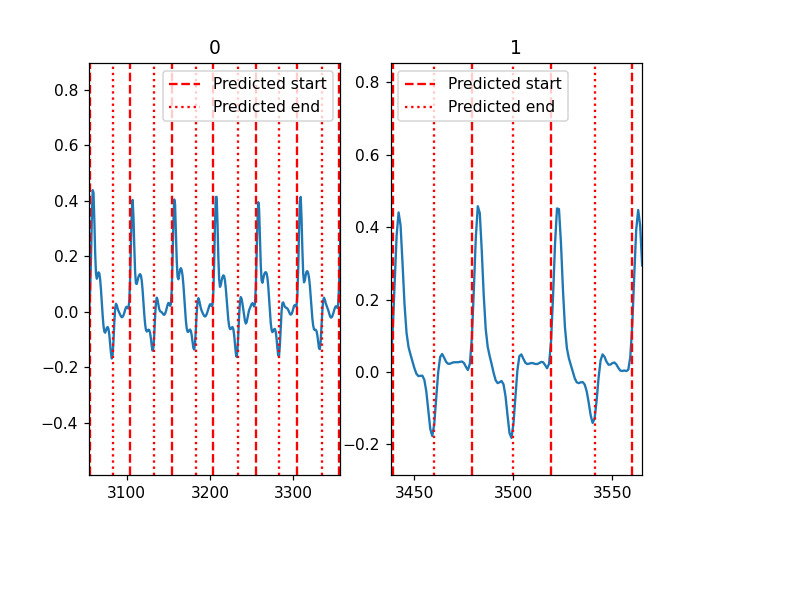

In [3]:
print('Pole:')
display_step_labeling_result_on_test(Activity.Pole)

### Evaluation

Boot


<IPython.core.display.Javascript object>


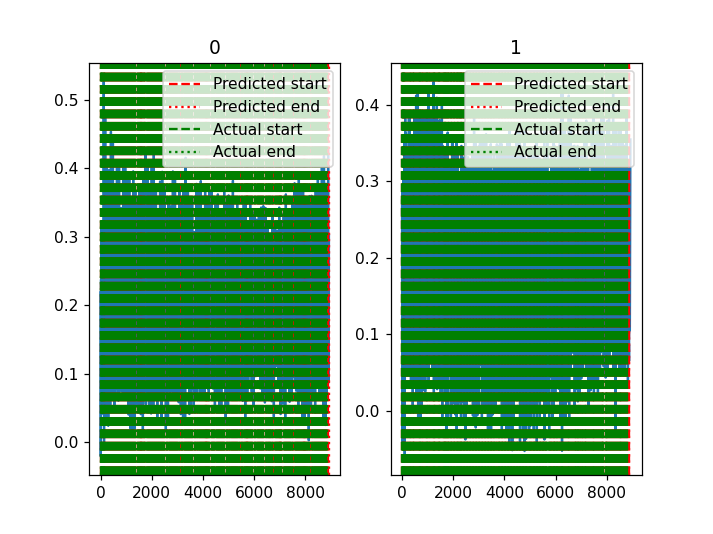

Test 0
Total steps: 109
Total steps predicted: 113
Accurate to within 1 datapoint:
- Start: 0.339450
- End: 0.587156
Accurate to within 2 datapoint:
- Start: 0.541284
- End: 0.880734

Test 1
Total steps: 139
Total steps predicted: 138
Accurate to within 1 datapoint:
- Start: 0.201439
- End: 0.568345
Accurate to within 2 datapoint:
- Start: 0.338129
- End: 0.812950



In [4]:
print('Boot')
evaluate_step_labeling_on_test(Activity.Boot)

Pole


<IPython.core.display.Javascript object>


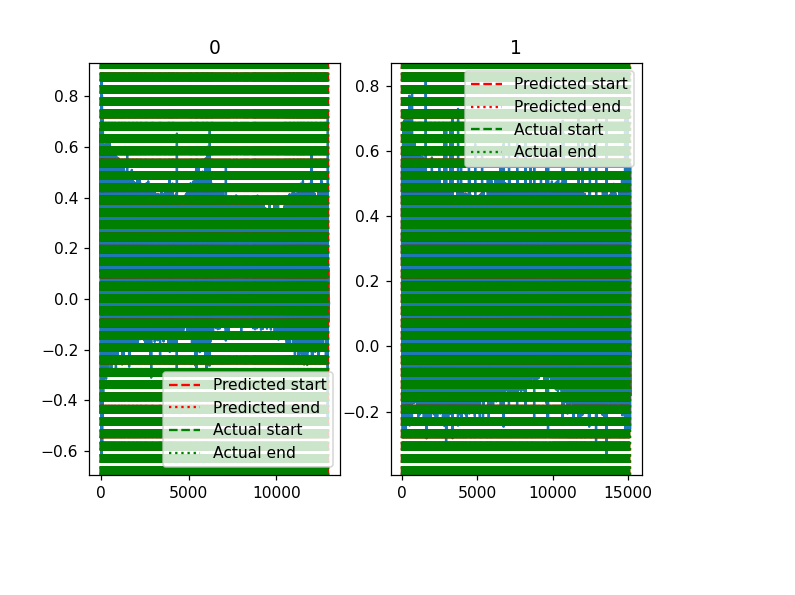

Test 0
Total steps: 261
Total steps predicted: 262
Accurate to within 1 datapoint:
- Start: 0.954023
- End: 0.942529
Accurate to within 2 datapoint:
- Start: 1.000000
- End: 0.992337

Test 1
Total steps: 364
Total steps predicted: 364
Accurate to within 1 datapoint:
- Start: 0.991758
- End: 0.978022
Accurate to within 2 datapoint:
- Start: 1.000000
- End: 0.986264



In [5]:
print('Pole')
evaluate_step_labeling_on_test(Activity.Pole)